# 13 - Review Predictions

This notebook demonstrates the application of a pre-trained XGBoost model to predict the suitability of candidates for a specific role. It shows the initial distribution of predictions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import json

from sklearn.utils import resample

/Users/markuskuehnle/Documents/projects/bias-fairness-mvp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define constants
DATA_PATH: str = "../app/data/static_data.parquet"
MODEL_PATH: str = "../models/xgb_model.pkl"
FEATURE_LIST_PATH: str = "../models/features.json"

In [3]:
data: pd.DataFrame = pd.read_parquet(DATA_PATH)

In [4]:
# Load the model
with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

In [6]:
# Function to load the feature list
def load_feature_list(feature_list_path: str) -> list:
    """
    Load the feature list from a JSON file.

    Parameters:
        feature_list_path (str): Path to the feature list file.

    Returns:
        list: List of feature names.
    """
    with open(feature_list_path, "r") as f:
        return json.load(f)

In [7]:
# Load the feature list
feature_list: list = load_feature_list(FEATURE_LIST_PATH)

In [8]:
# Filter the dataset to include only relevant features
data_filtered: pd.DataFrame = data[feature_list]

In [9]:
# Ensure numeric data for all columns in data_filtered
data_filtered = data_filtered.apply(pd.to_numeric, errors="coerce")

In [10]:
# Make predictions
predictions: pd.Series = model.predict_proba(data_filtered)[:, 1]  # Probability of being a good fit

In [11]:
# Add predictions and "Good Fit" label to the dataset
data["Prediction_Probability"] = predictions
data["Good_Fit"] = data["Prediction_Probability"] >= 0.5

In [12]:
data.shape

(1330, 246)

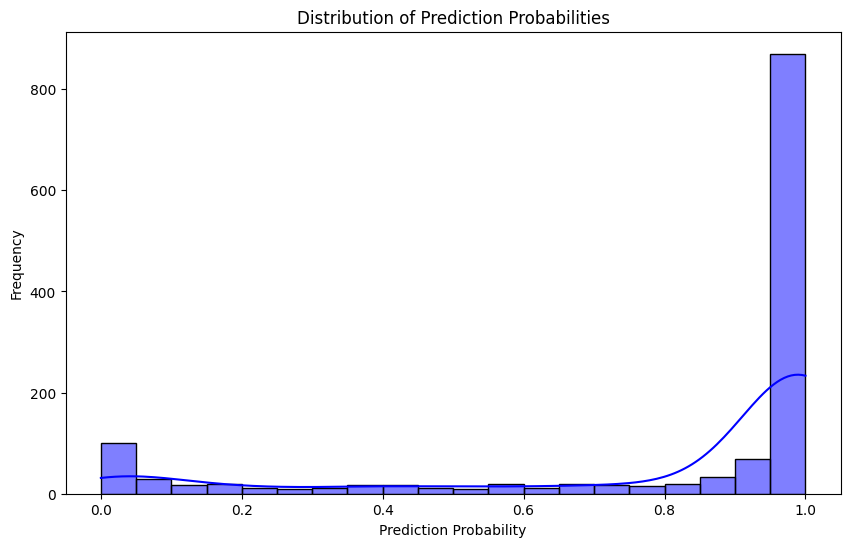

In [13]:
# Plot the distribution of prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(data["Prediction_Probability"], bins=20, kde=True, color="blue")
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.show()

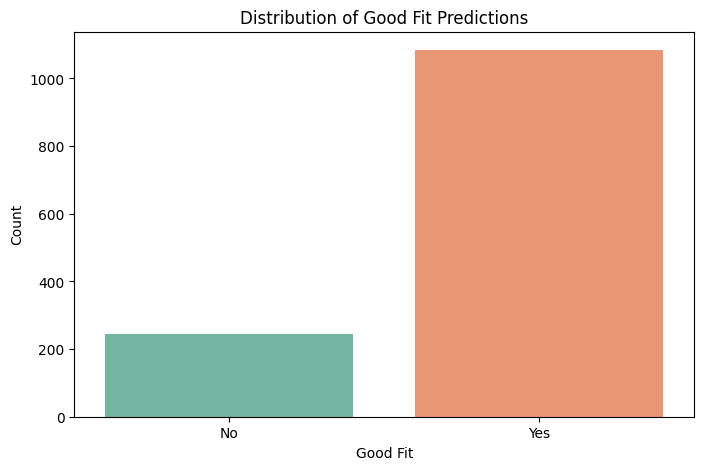

In [14]:
# Check the distribution of 'Good Fit' predictions
plt.figure(figsize=(8, 5))
sns.countplot(x="Good_Fit", data=data, hue="Good_Fit", dodge=False, palette="Set2", legend=False)
plt.title("Distribution of Good Fit Predictions")
plt.xlabel("Good Fit")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

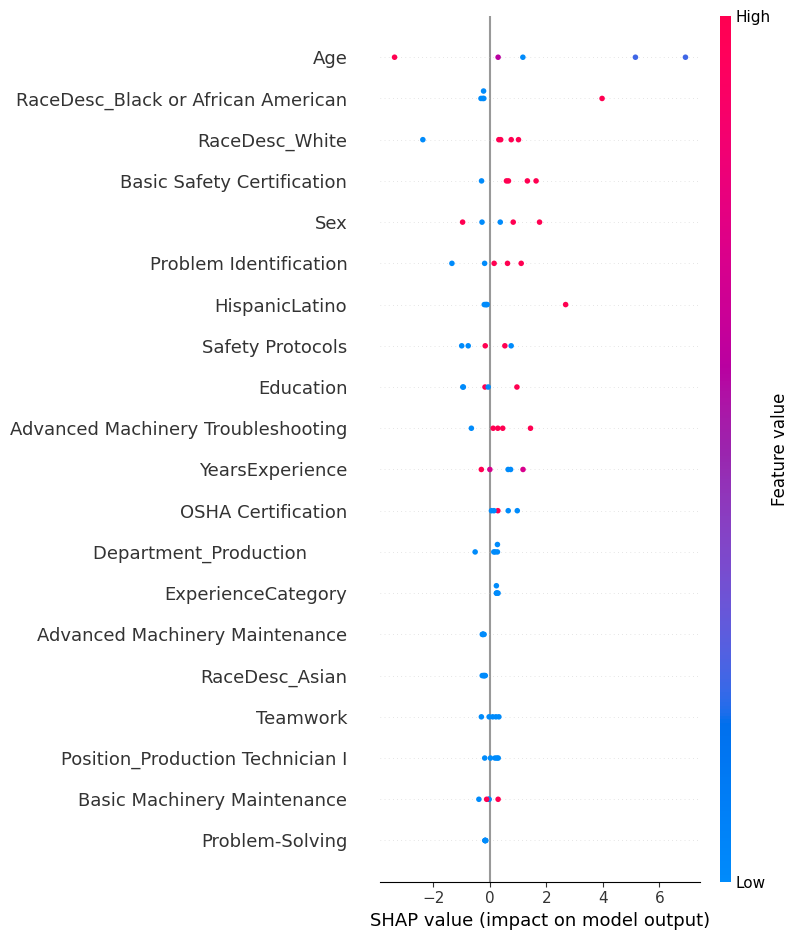

In [15]:
# Analyze top SHAP features for a random sample of candidates
explainer = shap.TreeExplainer(model)
random_sample: pd.DataFrame = data_filtered.sample(n=5, random_state=42)
shap_values = explainer(random_sample)

# Visualize SHAP values
shap.summary_plot(shap_values, random_sample, feature_names=feature_list)

## Dataset Downsampling

In [16]:
# Separate the data into two groups based on the "Good_Fit" column
good_fit: pd.DataFrame = data[data["Good_Fit"] == 1]
no_good_fit: pd.DataFrame = data[data["Good_Fit"] == 0]

In [17]:
# Calculate the target size for the "Good Fit" category
target_good_fit_size: int = len(no_good_fit) // 2

In [18]:
# Downsample the "Good Fit" group to achieve the desired ratio
good_fit_downsampled: pd.DataFrame = resample(
    good_fit,
    replace=False,
    n_samples=target_good_fit_size,
    random_state=42
)

In [19]:
# Combine the downsampled "Good Fit" group with the "No Good Fit" group
balanced_data: pd.DataFrame = pd.concat([no_good_fit, good_fit_downsampled])

In [20]:
# Shuffle the combined dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
# Check the new ratio
print("Balanced Data Good Fit Distribution:")
print(balanced_data["Good_Fit"].value_counts())

Balanced Data Good Fit Distribution:
Good_Fit
False    246
True     123
Name: count, dtype: int64


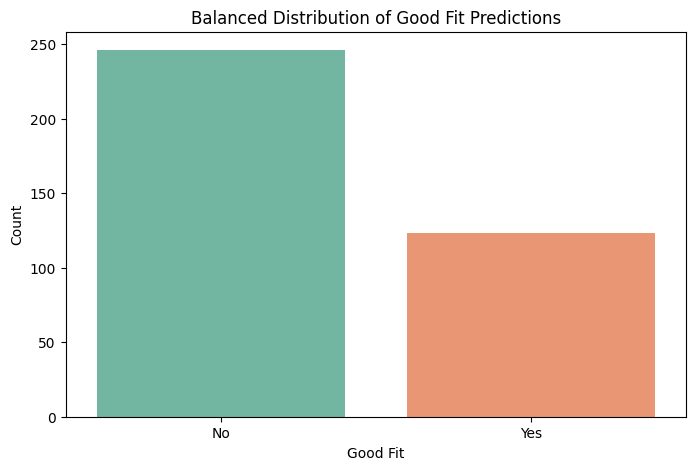

In [22]:
# Plot the distribution of balanced "Good Fit" predictions
plt.figure(figsize=(8, 5))
sns.countplot(
    x="Good_Fit",
    hue="Good_Fit",  # Assign the 'x' variable to 'hue'
    data=balanced_data,
    dodge=False,  # Ensure no separation between bars
    palette="Set2",
    legend=False  # Remove redundant legend
)
plt.title("Balanced Distribution of Good Fit Predictions")
plt.xlabel("Good Fit")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

In [23]:
balanced_data.head()
balanced_data.drop(columns=["Prediction_Probability", "Good_Fit"], inplace=True)

In [24]:
num_nan_rows = balanced_data.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 0


In [25]:
# Save the balanced data to a Parquet file
balanced_data.to_parquet(DATA_PATH, index=False)